# Step 1: Import packages


In [ ]:
!pip install --upgrade tensorflow

In [ ]:
import os
import numpy as np
from tensorflow import keras 
from tensorflow.keras import layers
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPool2D, Flatten
from numpy import array
from numpy import hstack
from sklearn import preprocessing
from sklearn.utils import shuffle
import pandas as pd
import matplotlib.pyplot as plt
import random
from random import sample
import math
print(tf.__version__) 
tf.test.gpu_device_name()

# Step 2: Mount Google drive

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks')
nb_path = '/content/notebooks'
os.symlink('/content/gdrive/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0, nb_path)
os.listdir()

# Step 3: Data preprocessing

### Basic data features
The input data are time series signals of 3-axis acceleration and jerk,  which have a common sampling rate of 25 Hertz. The acceleration signal is measured by the accelerometer of Himax WE-1 Plus EVB, and are process with a low pass filter, and the jerk signal is the derivative of acceleration.
The labels of classification of motion are idle, cruise, start, stop, turning left and turning right.

In [ ]:
n_features = 6 # ax, ay, az, jx, jy, jz
n_class = 6    # idle, cruise, start, stop, left, right

## a. Read CSV files from drive

In [ ]:
def read_file(file_path, file_name, n_class):
  '''
  This function reads a CSV file, generate a dataset that contains 3-axis acceleration and jerk,
  and classification of motions in one-hot format.
  '''
  # Load CSV file
  #print(file_name)
  read_data = pd.read_csv(file_path + file_name)  
  # read all features in Dataframe
  # acceleration
  ax = read_data['ax'].to_numpy()
  ay = read_data['ay'].to_numpy()
  az = read_data['az'].to_numpy()
  # jerk
  jx = read_data['jx'].to_numpy()
  jy = read_data['jy'].to_numpy()
  jz = read_data['jz'].to_numpy()
  # categories of motion
  m_int = read_data['class'].to_numpy()

  acc = hstack((ax.reshape(-1, 1), ay.reshape(-1, 1), az.reshape(-1, 1)))
  jerk = hstack((jx.reshape(-1, 1), jy.reshape(-1, 1), jz.reshape(-1, 1)))

  # Convert classification of motion to one-hot format
  motion = []
  for i in range(m_int.shape[0]):
    m_onehot = np.eye(n_class)[m_int[i]]
    motion.append(m_onehot)

  motion = array(motion)

  dataset = hstack((acc, jerk, motion))

  return dataset

### Tool for visualizing data
This is a useful function to visualize the waveform and classification of motion of our data.

In [ ]:
def plot_data(dataset):
  '''
  A plot tool that visualizing the informatoin of a dataset,
  including acceleration, jerk and classification
  '''
  plt.figure(figsize=(50, 12.5))
  colors = ['k', 'b', 'g', 'r', 'm', 'y']

  plt.subplot(311)  
  plt.plot(dataset[:,0], label = 'ax')
  plt.plot(dataset[:,1], label = 'ay')
  plt.plot(dataset[:,2], label = 'az')
  marker = 0
  c = np.argmax(dataset[0,6:])
  for x in range(0, dataset.shape[0]):
      if (np.argmax(dataset[x,6:]) != c):
          plt.axvspan(marker, x, facecolor=colors[c], alpha=0.2)
          marker = x
          c = np.argmax(dataset[x,6:])
  plt.axvspan(marker, dataset.shape[0], facecolor=colors[c], alpha=0.2)
  plt.grid()
  plt.title('acc')
  plt.legend()

  plt.subplot(312)
  plt.plot(dataset[:,3], label = 'jx')
  plt.plot(dataset[:,4], label = 'jy')
  plt.plot(dataset[:,5], label = 'jz')
  marker = 0
  c = np.argmax(dataset[0,6:])
  for x in range(0, dataset.shape[0]):
      if (np.argmax(dataset[x,6:]) != c):
          plt.axvspan(marker, x, facecolor=colors[c], alpha=0.2)
          marker = x
          c = np.argmax(dataset[x,6:])
  plt.axvspan(marker, dataset.shape[0], facecolor=colors[c], alpha=0.2)
  plt.grid()
  plt.title('jerk')
  plt.legend()

  plt.subplot(313)
  classes = [np.argmax(dataset[i][6:]) for i in range(len(dataset))]
  plt.plot(classes)
  plt.ylim([0, 5])
  plt.grid()
  plt.title('class')

  plt.show()

### Separate training  data and valid data
We split the files into training set and valid set before loading the CSV files to gurantee their is no overlapping data between training and valid data while training models.

In [ ]:
def split_files(file_path, ratio):
  '''
  This function separates our files into training files and valid files.
  '''
  # ratio: (# of valid file) / (# of all files)

  all_files = os.listdir(file_path)
  valid_num = int(ratio*len(all_files))
  valid_files = random.sample(all_files, valid_num)
  train_files = list(set(all_files).difference(set(valid_files)))
  
  return train_files, valid_files

In [ ]:
def generate_dataset(file_path, n_class, ratio):
  '''
  This function read all files in path(file_path), and split the files into training set and validation set,
  reading the files in each set, and generate datasets for training and validating.
  The output contains two list, each list contains datasets from each files.
  '''

  # ratio = (# of files for validation)/(# of all files)

  train_files, valid_files = split_files(file_path, ratio)
  print('train:',train_files)
  print('valid:',valid_files)
  train_dataset = []
  valid_dataset = []

  for i in range(len(train_files)):
    data_t = read_file(file_path, train_files[i], n_class)
    train_dataset.append(data_t)

  for i in range(len(valid_files)):
    data_v = read_file(file_path, valid_files[i], n_class)
    valid_dataset.append(data_v)

  return train_dataset, valid_dataset

In [ ]:
################################################################################
#       LOAD FILES AND SEPARATING THE DATASET WILL BE USED FOR TRAINING        #
################################################################################
train_path = '/content/drive/My Drive/Colab Notebooks/Training_strict/'
train_dataset, valid_dataset = generate_dataset(train_path, n_class, 0.3)
print(len(train_dataset))
print(len(valid_dataset))

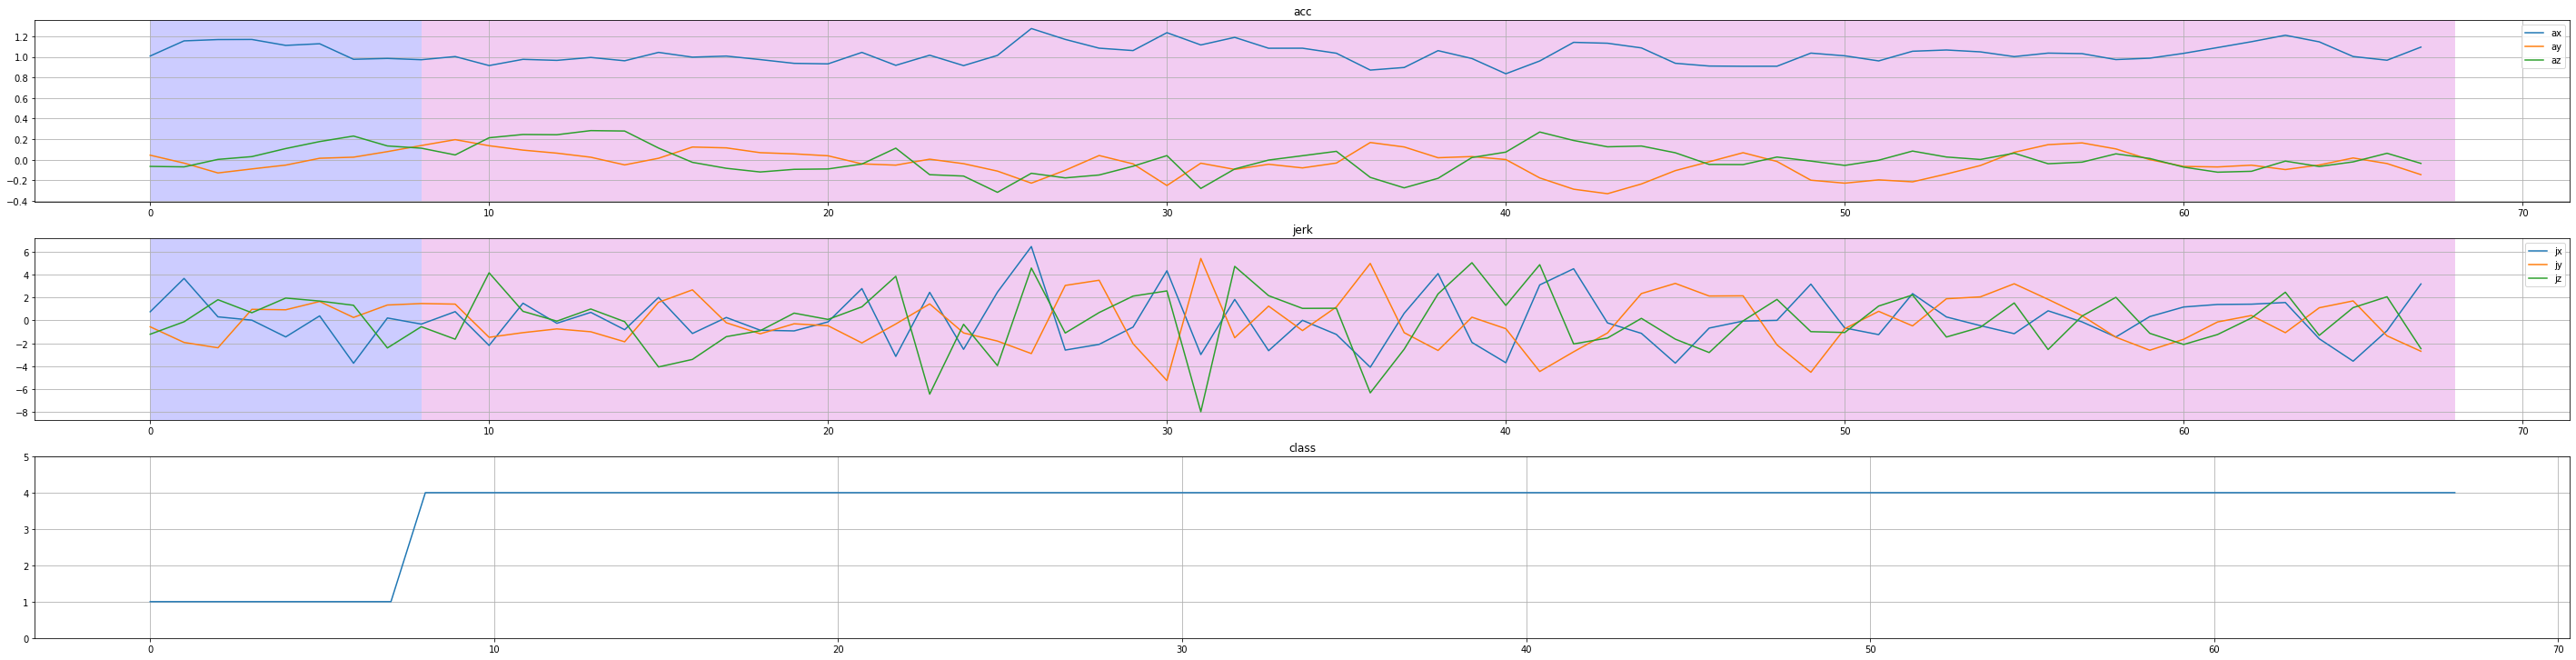

In [ ]:
plot_data(train_dataset[0])

## b. Separate diffirent class
A CSV file may contain different class of motion, we separate the data of different class, and  group the data of same class from every file.

In [ ]:
def separate_class(list_of_datasets, n_class):
  '''
  We have to select a sequential part in dataset that has same class,
  then add  the part to the new list that contains parts of dataset of specific class.
  '''

  # list_of_datasets: a list that contains dataset from each file 

  datas_0, datas_1,datas_2, datas_3, datas_4, datas_5 = [], [], [], [], [], []
  temp = []
  last_class = np.argmax(list_of_datasets[0][0][6:])

  for j in range(len(list_of_datasets)):
    for i in range(list_of_datasets[j].shape[0]):
      arr_data = list_of_datasets[j][i]
      m_class = np.argmax(arr_data[6:])
      if m_class == last_class:
        temp.append(arr_data)
      else:
        if last_class == 0:
          datas_0.append(array(temp))
        elif last_class == 1:
          datas_1.append(array(temp))
        elif last_class == 2:
          datas_2.append(array(temp))
        elif last_class == 3:
          datas_3.append(array(temp))
        elif last_class == 4:
          datas_4.append(array(temp))
        elif last_class == 5:
          datas_5.append(array(temp)) 

        temp = []
        temp.append(arr_data)

      last_class = m_class

    if last_class == 0:
      datas_0.append(array(temp))
    elif last_class == 1:
      datas_1.append(array(temp))
    elif last_class == 2:
      datas_2.append(array(temp))
    elif last_class == 3:
      datas_3.append(array(temp))
    elif last_class == 4:
      datas_4.append(array(temp))
    elif last_class == 5:
      datas_5.append(array(temp))    

  return datas_0, datas_1,datas_2, datas_3, datas_4, datas_5

### Tool for estimating the size of data

In [ ]:
def data_size(data):
  '''
  A function to calaculate the size of dataset.
  '''
  size = 0
  for i in range(len(data)):
    size += data[i].shape[0]
  return size, data[0].shape[1]

In [ ]:
################################################################################
#             SEPARATE THE TRAINING  AND VALID DATASETS BY CLASSES             #
################################################################################
train_idle, train_cruise, train_acc, train_brake, train_left, train_right = separate_class(train_dataset, n_class)
valid_idle, valid_cruise, valid_acc, valid_brake, valid_left, valid_right = separate_class(valid_dataset, n_class)
################################################################################
#               SHOWING THE SIZE OF TRAINING AND VALID DATASETS                #
################################################################################
print('RAW DATA:')
print('-----TRAINING-----')
print('Idle  :', data_size(train_idle))
print('Cruise:', data_size(train_cruise))
print('Acc   :', data_size(train_acc))
print('Brake :', data_size(train_brake))
print('Left  :', data_size(train_left))
print('Right :', data_size(train_right))
print('----VALIDATION----')
print('Idle  :', data_size(valid_idle))
print('Cruise:', data_size(valid_cruise))
print('Acc   :', data_size(valid_acc))
print('Brake :', data_size(valid_brake))
print('Left  :', data_size(valid_left))
print('Right :', data_size(valid_right))

## c. Data augmentation
We use rotation matrix to rotate some part of original data, the results are added to the training set.

In [ ]:
def rotate_data(dataset, degrees):
  '''
  This function returns a new dataset which is a result of rotation matrix 
  multiply with input dataset.
  '''

  # dataset: input dataset 
  # degrees(theta_x, theta_y, theta_z): input rotation angles for three axis in degree
  
  # Convert  three angles to radian format
  theta_x = np.radians(degrees[0])                       
  theta_y = np.radians(degrees[1])
  theta_z = np.radians(degrees[2])
  # Define the rotation matrix
  Rx = np.array([[1, 0, 0], [0, math.cos(theta_x), -1*math.sin(theta_x)], [0, math.sin(theta_x), math.cos(theta_x)]])
  Ry = np.array([[math.cos(theta_y), 0, math.sin(theta_y)], [0, 1, 0], [-1*math.sin(theta_y), 0, math.cos(theta_y)]])
  Rz = np.array([[math.cos(theta_z), -math.sin(theta_z), 0 ], [math.sin(theta_z), math.cos(theta_z), 0], [0, 0, 1]])

  ax_r = []
  ay_r = []
  az_r = []
  jx_r = []
  jy_r = []
  jz_r = []

  for i in range(dataset.shape[0]):
    # Calculate the dot products
    acc = dataset[i][0:3]
    acc_ri = acc.dot(Rx).dot(Ry).dot(Rz)
    ax_r.append(acc_ri[0])
    ay_r.append(acc_ri[1])
    az_r.append(acc_ri[2])

    jerk = dataset[i][3:6]
    jerk_ri = jerk.dot(Rx).dot(Ry).dot(Rz)
    jx_r.append(jerk_ri[0])
    jy_r.append(jerk_ri[1])
    jz_r.append(jerk_ri[2])

  ax_r = array(ax_r)
  ay_r = array(ay_r)
  az_r = array(az_r)
  acc_r = hstack((ax_r.reshape(-1, 1), ay_r.reshape(-1, 1), az_r.reshape(-1, 1)))

  jx_r = array(jx_r)
  jy_r = array(jy_r)
  jz_r = array(jz_r)
  jerk_r = hstack((jx_r.reshape(-1, 1), jy_r.reshape(-1, 1), jz_r.reshape(-1, 1)))  

  motion = []
  m_onehot = dataset[:,6:][0]
  for i in range(dataset.shape[0]):
   motion.append(m_onehot)

  dataset_r = hstack((acc_r, jerk_r, array(motion)))

  return  dataset_r

In [ ]:
def generate_aug_data(list_of_datasets, degrees, aug_ratio):
  '''
  This function controlls how to augment our dataset, including the ratio of augmentation
  and angles for rotation matrix.
  '''
  # list_of_dataset: list of datasets
  # degrees: the rotation angles along 3 axis
  # aug_ratio: ((# of all datasets in list_of_datasets)/(# chosen datasets))

  theta_x, theta_y, theta_z = degrees

  if aug_ratio == 0:
    return list_of_datasets

  pick_num = int(aug_ratio*len(list_of_datasets)/2)
  pick_data = sample(list_of_datasets, pick_num)
  aug_data = list(list_of_datasets)

  batch = int(pick_num/3)

  for i in range(batch):
    new_data_1 = rotate_data(pick_data[i], (theta_x, 0, 0))
    new_data_2 = rotate_data(pick_data[i], (-1*theta_x, 0, 0))
    aug_data.append(new_data_1)
    aug_data.append(new_data_2)

  for i in range(batch, 2*batch):
    new_data_3 = rotate_data(pick_data[i], (0, theta_y, 0))
    new_data_4 = rotate_data(pick_data[i], (0, -1*theta_y, 0))
    aug_data.append(new_data_3)
    aug_data.append(new_data_4)

  for i in range(2*batch, pick_num):
    new_data_5 = rotate_data(pick_data[i], (0, 0, theta_z))
    new_data_6 = rotate_data(pick_data[i], (0, 0, -1*theta_z))
    aug_data.append(new_data_5)
    aug_data.append(new_data_6)

  return aug_data

In [ ]:
################################################################################
#                    AUGMENTING TRAINING AND VALID DATASETS                    #
################################################################################
train_idle_aug = generate_aug_data(train_idle, degrees=(2,4,2), aug_ratio=1)
train_cruise_aug = generate_aug_data(train_cruise, degrees=(0.5,4,0.5), aug_ratio=0.2)
train_acc_aug = generate_aug_data(train_acc, degrees=(2,4,2), aug_ratio=1)
train_brake_aug = generate_aug_data(train_brake, degrees=(2,4,2), aug_ratio=1)
train_left_aug = generate_aug_data(train_left, degrees=(2,4,2), aug_ratio=1)
train_right_aug = generate_aug_data(train_right, degrees=(2,4,2), aug_ratio=1)
################################################################################
valid_idle_aug = generate_aug_data(valid_idle, degrees=(1,5,1), aug_ratio=0)
valid_cruise_aug = generate_aug_data(valid_cruise, degrees=(1,5,1), aug_ratio=0)
valid_acc_aug = generate_aug_data(valid_acc, degrees=(1,5,1), aug_ratio=0)
valid_brake_aug = generate_aug_data(valid_brake, degrees=(1,5,1), aug_ratio=0)
valid_left_aug = generate_aug_data(valid_left, degrees=(1,5,1), aug_ratio=0)
valid_right_aug = generate_aug_data(valid_right, degrees=(1,5,1), aug_ratio=0)
################################################################################
#                   SHOWING THE SIZES OF AUGMENTED DATASETS                    #
################################################################################
print('-----TRAINING-----')
print('Idle  :', data_size(train_idle_aug))
print('Cruise:', data_size(train_cruise_aug))
print('Acc   :', data_size(train_acc_aug))
print('Brake :', data_size(train_brake_aug))
print('Left  :', data_size(train_left_aug))
print('Right :', data_size(train_right_aug))
print('----VALIDATION-----')
print('Idle  :', data_size(valid_idle_aug))
print('Cruise:', data_size(valid_cruise_aug))
print('Acc   :', data_size(valid_acc_aug))
print('Brake :', data_size(valid_brake_aug))
print('Left  :', data_size(valid_left_aug))
print('Right :', data_size(valid_right_aug))

## d. Normalize dataset
We normalize the input data before training by the formula :
$$			
N(x) = (x - \bar{x})/\sigma
$$
The means and standard variantions are calculated using each feature of training set.

### Calculating means and stds of training datasets

In [ ]:
def cat_features(list_of_datasets):
  '''
  This function returns 6 lists which contain elements from 6 features,
  since the input list(list_of_datasets) have multiple datasets, 
  the function must add elements from every dataset in the input list to the output lists
  '''
  ax ,ay, az, jx, jy, jz = list(), list(), list(), list(), list(), list()
  for i in range(len(list_of_datasets)):
    ax.extend(list(list_of_datasets[i][:,0]))
    ay.extend(list(list_of_datasets[i][:,1]))
    az.extend(list(list_of_datasets[i][:,2]))
    jx.extend(list(list_of_datasets[i][:,3]))
    jy.extend(list(list_of_datasets[i][:,4]))
    jz.extend(list(list_of_datasets[i][:,5]))
  return ax ,ay, az, jx, jy, jz

In [ ]:
def get_mean_and_std(datasets_0, datasets_1, datasets_2, datasets_3, datasets_4, datasets_5):
  '''
  The 6 input list of datasets are of different classes.
  Calling the "cat_features()" function to get output lists of each input list of datasets,
  then concatenate the 36 lists of features to 6 larger lists.
  Finally we can use np.mean and np.std to get means and stds.
  '''
  ax_0 ,ay_0, az_0, jx_0, jy_0, jz_0 = cat_features(datasets_0)
  ax_1 ,ay_1, az_1, jx_1, jy_1, jz_1 = cat_features(datasets_1)
  ax_2 ,ay_2, az_2, jx_2, jy_2, jz_2 = cat_features(datasets_2)
  ax_3 ,ay_3, az_3, jx_3, jy_3, jz_3 = cat_features(datasets_3)
  ax_4 ,ay_4, az_4, jx_4, jy_4, jz_4 = cat_features(datasets_4)
  ax_5 ,ay_5, az_5, jx_5, jy_5, jz_5 = cat_features(datasets_5)

  ax = array(ax_0 + ax_1 + ax_2 + ax_3 + ax_4 + ax_5)
  ay = array(ay_0 + ay_1 + ay_2 + ay_3 + ay_4 + ay_5)
  az = array(az_0 + az_1 + az_2 + az_3 + az_4 + az_5)
  jx = array(jx_0 + jx_1 + jx_2 + jx_3 + jx_4 + jx_5)
  jy = array(jy_0 + jy_1 + jy_2 + jy_3 + jy_4 + jy_5)
  jz = array(jz_0 + jz_1 + jz_2 + jz_3 + jz_4 + jz_5)

  means = [np.mean(ax), np.mean(ay), np.mean(az), np.mean(jx), np.mean(jy), np.mean(jz)]
  stds = [np.std(ax, ddof=0), np.std(ay, ddof=0), np.std(az, ddof=0), np.std(jx, ddof=0), np.std(jy, ddof=0), np.std(jz, ddof=0)]

  return means, stds

In [ ]:
################################################################################
#               CALCULATING MEANS AND STDS OF "TRAINING" DATASETS              #
################################################################################
means, stds = get_mean_and_std(train_idle_aug, train_cruise_aug, train_acc_aug, train_brake_aug, train_left_aug, train_right_aug)
print('Means:', means)
print('Stds :', stds)

### Nornalizing datasets

In [ ]:
def normalize(list_of_datasets, means, stds):
  '''
  N(x) = (x-mean)/std
  Using the above funtion to normalize the datasets in the input list
  '''
  norm_datasets = list_of_datasets

  for i in range(len(list_of_datasets)):
    for j in range(list_of_datasets[i].shape[0]):
      seq = list_of_datasets[i][j] 
      for k in range(6):
        seq[k] = (seq[k] - means[k])/stds[k]
      norm_datasets[i][j] = seq
  
  return norm_datasets

In [ ]:
################################################################################
#                  NORMALIZING THE TRAINING AND VALID DATASETS                 #
################################################################################
train_idle_norm = normalize(train_idle_aug, means, stds)
train_cruise_norm = normalize(train_cruise_aug, means, stds)
train_acc_norm = normalize(train_acc_aug, means, stds)
train_brake_norm = normalize(train_brake_aug, means, stds)
train_left_norm = normalize(train_left_aug, means, stds)
train_right_norm = normalize(train_right_aug, means, stds)
################################################################################
valid_idle_norm = normalize(valid_idle_aug, means, stds)
valid_cruise_norm = normalize(valid_cruise_aug, means, stds)
valid_acc_norm = normalize(valid_acc_aug, means, stds)
valid_brake_norm = normalize(valid_brake_aug, means, stds)
valid_left_norm = normalize(valid_left_aug, means, stds)
valid_right_norm = normalize(valid_right_aug, means, stds)

## e. Split data sequences
We choose a value to be the length of our training sequences, and generate the sequences for training and validation. The output x is the training sequence, containing the consequent time series signals of length *n_steps*, y1 is the category of motion in the duration of  x, and y2 is the information after the time of  x. y1 is the labeled data of classifier model, and y2 is the labeled data of predictor model, both model has the common input training data x. 

| Output | Meaning                         |
| ------ | ------------------------------------------------------------ |
| x      | Time series of information from t<sub>start</sub> to t<sub>start+n_steps</sub> |
| y1     | The class of motion of t<sub>start</sub> to t<sub>start+n_steps</sub> |
| y2     | The information of t<sub>start+n_steps+1</sub>                     |

In [ ]:
def split_dataset(dataset, n_steps):
  '''
  This function split input dataset into three outputs:
  x: an array with shape(len(dataset) - n_steps + 1, n_steps, 6), 
  containing the information in a time interval has duration equals to n_steps.
  y1: the classification of motion of x.
  y2: the information next to the last time information of x.
  '''
  x, y1, y2 = list(), list(), list()
  # x: states of vehicle has duration is equal to n_steps 
  # y1: category of the motion
  # y2: next state of the vehicle  
  for i in range(len(dataset)):
    end_ix = i + n_steps
    # check if index is output of bound
    if end_ix > len(dataset)-1:
      break

    seq_x, seq_y1, seq_y2 = dataset[i:end_ix, :6], dataset[end_ix-1, 6:], dataset[end_ix, :3]
    x.append(seq_x)
    y1.append(seq_y1)
    y2.append(seq_y2)
  
  return array(x), array(y1), array(y2)

In [ ]:
def generate_seq(list_of_datasets, n_steps):
  '''
  This is an higher level function,   which splits all datasets in 
  list_of_datasets into sequences.
  '''
  x, y1, y2 = np.empty(shape=(0,n_steps,6)), np.empty(shape=(0,6)), np.empty(shape=(0,3))
  for i in range(len(list_of_datasets)):
    # Check if the dataset is longer than n_steps
    if list_of_datasets[i].shape[0] <= n_steps:
      #print('skip')
      continue
    tx, ty1, ty2 = split_dataset(list_of_datasets[i], n_steps)
    #print('i:',i,'/',tx.shape, ty1.shape, ty2.shape)
    x = np.append(x, tx, axis=0)
    y1 = np.append(y1, ty1, axis=0)
    y2 = np.append(y2, ty2, axis=0)
  
  return array(x), array(y1), array(y2)

In [ ]:
n_steps = 30   # customize
################################################################################
#                 SPLITTING TRAINING AND VALIDATION SEQUENCES                  #
################################################################################
x_train_idle, y1_train_idle, y2_train_idle = generate_seq(train_idle_norm, n_steps)
x_train_cruise, y1_train_cruise, y2_train_cruise = generate_seq(train_cruise_norm, n_steps)
x_train_acc, y1_train_acc, y2_train_acc = generate_seq(train_acc_norm, n_steps)
x_train_brake, y1_train_brake, y2_train_brake = generate_seq(train_brake_norm, n_steps)
x_train_left, y1_train_left, y2_train_left = generate_seq(train_left_norm, n_steps)
x_train_right, y1_train_right, y2_train_right = generate_seq(train_right_norm, n_steps)
################################################################################
x_valid_idle, y1_valid_idle, y2_valid_idle = generate_seq(valid_idle_norm, n_steps)
x_valid_cruise, y1_valid_cruise, y2_valid_cruise = generate_seq(valid_cruise_norm, n_steps) ###########
x_valid_acc, y1_valid_acc, y2_valid_acc = generate_seq(valid_acc_norm, n_steps)
x_valid_brake, y1_valid_brake, y2_valid_brake = generate_seq(valid_brake_norm, n_steps)
x_valid_left, y1_valid_left, y2_valid_left = generate_seq(valid_left_norm, n_steps)
x_valid_right, y1_valid_right, y2_valid_right = generate_seq(valid_right_norm, n_steps)  
################################################################################
#                        SHOWING THE SIZE OF EACH CLASS                        #
################################################################################
print('----------TRAINING----------')
print('x_train_idle  :', x_train_idle.shape)
print('x_train_cruise:', x_train_cruise.shape)
print('x_train_acc   :', x_train_acc.shape)
print('x_train_brake :', x_train_brake.shape)
print('x_train_left  :', x_train_left.shape)
print('x_train_right :', x_train_right.shape)
print('---------VALIDATION---------')
print('x_valid_idle  :', x_valid_idle.shape)
print('x_valid_cruise:', x_valid_cruise.shape)
print('x_valid_acc   :', x_valid_acc.shape)
print('x_valid_brake :', x_valid_brake.shape)
print('x_valid_left  :', x_valid_left.shape)
print('x_valid_right :', x_valid_right.shape)

In [ ]:
################################################################################
#                   BALENCING THE DATA SIZE OF EACH CLASS                      #
################################################################################
x_train_idle, y1_train_idle, y2_train_idle = shuffle(x_train_idle, y1_train_idle, y2_train_idle, random_state=0)
x_train_cruise, y1_train_cruise, y2_train_cruise = shuffle(x_train_cruise, y1_train_cruise, y2_train_cruise, random_state=0)
x_train_acc, y1_train_acc, y2_train_acc = shuffle(x_train_acc, y1_train_acc, y2_train_acc, random_state=0)
x_train_brake, y1_train_brake, y2_train_brake = shuffle(x_train_brake, y1_train_brake, y2_train_brake, random_state=0)
x_train_left, y1_train_left, y2_train_left = shuffle(x_train_left, y1_train_left, y2_train_left, random_state=0)
x_train_right, y1_train_right, y2_train_right = shuffle(x_train_right, y1_train_right, y2_train_right, random_state=0)
################################################################################
x_valid_idle, y1_valid_idle, y2_valid_idle = shuffle(x_valid_idle, y1_valid_idle, y2_valid_idle, random_state=0)
x_valid_cruise, y1_valid_cruise, y2_valid_cruise = shuffle(x_valid_cruise, y1_valid_cruise, y2_valid_cruise, random_state=0) 
x_valid_acc, y1_valid_acc, y2_valid_acc = shuffle(x_valid_acc, y1_valid_acc, y2_valid_acc, random_state=0)
x_valid_brake, y1_valid_brake, y2_valid_brake = shuffle(x_valid_brake, y1_valid_brake, y2_valid_brake, random_state=0)
x_valid_left, y1_valid_left, y2_valid_left = shuffle(x_valid_left, y1_valid_left, y2_valid_left, random_state=0)
x_valid_right, y1_valid_right, y2_valid_right = shuffle(x_valid_right, y1_valid_right, y2_valid_right, random_state=0)

l1 = [len(x_train_idle), len(x_train_acc), 
      len(x_train_brake), len(x_train_left), len(x_train_right)]
m1 = max(l1)

l2 = [len(x_valid_idle), len(x_valid_cruise), len(x_valid_acc), 
      len(x_valid_brake), len(x_valid_left), len(x_valid_right)] 
m2 = min(l2)

## f. Concatenate and shuffle sequences

In [ ]:
################################################################################
#              CONCATENATING TRAINING AND VALIDATION SEQUENCES                 #
################################################################################
x_train = np.concatenate((x_train_idle, x_train_cruise[:m1], x_train_acc, 
                          x_train_brake, x_train_left, x_train_right))
y1_train = np.concatenate((y1_train_idle, y1_train_cruise[:m1], y1_train_acc,
                          y1_train_brake, y1_train_left, y1_train_right))
y2_train = np.concatenate((y2_train_idle, y2_train_cruise[:m1], y2_train_acc, 
                           y2_train_brake, y2_train_left, y2_train_right))
################################################################################
x_valid = np.concatenate((x_valid_idle[:m2], x_valid_cruise[:m2], x_valid_acc[:m2], 
                          x_valid_brake[:m2], x_valid_left[:m2], x_valid_right[:m2]))
y1_valid = np.concatenate((y1_valid_idle[:m2], y1_valid_cruise[:m2], y1_valid_acc[:m2], 
                           y1_valid_brake[:m2], y1_valid_left[:m2], y1_valid_right[:m2]))
y2_valid = np.concatenate((y2_valid_idle[:m2], y2_valid_cruise[:m2], y2_valid_acc[:m2], 
                           y2_valid_brake[:m2], y2_valid_left[:m2], y2_valid_right[:m2]))
################################################################################
#                 SHUFFLLING TRAINING AND VALIDATION SEQUENCES                 #
################################################################################
x_train, y1_train, y2_train = shuffle(x_train, y1_train, y2_train, random_state=0)
x_valid, y1_valid, y2_valid = shuffle(x_valid, y1_valid, y2_valid, random_state=0)
################################################################################
#               SHOWING THE SIZE OF TRAINING AND VALIDATION DATA               #
################################################################################
print('----TRAINING----')
print('x_train :', x_train.shape)
print('y1_train:', y1_train.shape)
print('y2_train:', y2_train.shape)
print('---VALIDATION---')
print('x_valid :', x_valid.shape)
print('y1_valid:', y1_valid.shape)
print('y2_valid:', y2_valid.shape)

# Step 4: Build models

## 1.Classifier model
The classifier is a model which classifies the input sequences into six different categories of motions. The input of classifier model is the acceleration and jerk of the last *n* samples, and the output is one of the above six state.

| Input                                        | Output                     |
| ------------------------------------------- | -------------------------- |
| Latest *n* samples of acceleration and jerk | Category of current motion |

#### Inception module
An inception cell contains two primary branches, one is bottleneck branch. A bottleneck layer is used to reduce the dimensionality of the inputs.
 this branch has its three Conv1D branches of different kernel size to specify long-term, mid-term and short-term features. The other one is maxpooling branch and follow by a Conv1D layer with kernel size equals to 1.
The four Conv1D layer are concatenate along the depth dimension.

In [ ]:
  def inception_cell_1D(inputs, num_bn, num_filters):
    # Step 1
    # Bottleneck and maxpooling layers
    bottleneck =layers.Conv1D(filters=num_bn, kernel_size=num_bn, strides=1,
                         activation='relu', padding='same', use_bias=False)(inputs)
    maxpool = layers.MaxPool1D(pool_size=3,strides=1,padding='same')(inputs)

    # Step 2
    # Convolution layers after bottleneck layer
    # Long-term
    c0 = layers.Conv1D(filters=num_filters,kernel_size=28, strides=1,
                         activation='relu', padding='same', use_bias=False)(bottleneck)
    # Mid-term
    c1 = layers.Conv1D(filters=num_filters,kernel_size=14, strides=1,
                         activation='relu', padding='same', use_bias=False)(bottleneck)   
    # Short-term
    c2 = layers.Conv1D(filters=num_filters,kernel_size=7, strides=1,
                         activation='relu', padding='same', use_bias=False)(bottleneck)
    # Convolution layer after maxpool layer
    c3 = layers.Conv1D(filters=num_filters,kernel_size=1, strides=1,
                         activation='relu', padding='same', use_bias=False)(maxpool)
  
    # Step 3
    c = layers.concatenate([c0, c1, c2, c3], axis=2)     
    c = layers.BatchNormalization()(c)
    c = layers.Activation(activation='relu')(c) 
    print('output:', c.shape)
    return c

### Short cut layer
Creating a short cut branch for model and forming the residual structure.

In [ ]:
def shortcut_layer(inputs, c_inception):
  # create shortcut connection
  c_shortcut = layers.Conv1D(filters=c_inception.shape[-1], kernel_size=1,
                             padding='same', use_bias=False)(inputs)
  c_shortcut = layers.BatchNormalization()(c_shortcut)
  # add short cut to inception
  c = layers.Add()([c_shortcut, c_inception])

  return layers.Activation('relu')(c)

### Build model
A complete classifier model is built by three inception cell, including one residual net work from input layer to the second
inception cell, and the flatten and output layers.

In [ ]:
input_layer_1D = keras.Input(shape=(n_steps,6), name='inputs')
c = input_layer_1D

c_residual = input_layer_1D

c = inception_cell_1D(c, 1, 4)
c = inception_cell_1D(c, 1, 4)
c = shortcut_layer(c_residual, c)
c_residual = c
c = inception_cell_1D(c, 1, 4)

d = layers.Flatten()(c)
#d = layers.Dropout(0.1)(d)

output_layer = layers.Dense(n_class, activation='softmax')(d)
classifier = keras.Model(inputs=input_layer_1D, outputs=output_layer)

output: (None, 30, 16)
output: (None, 30, 16)
output: (None, 30, 16)


In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.00025, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0, amsgrad=False)
classifier_path = '/content/drive/My Drive/Colab Notebooks/KerasModels/Classifier/classifier.h5'
check_pt_c = keras.callbacks.ModelCheckpoint(classifier_path, monitor='val_loss', verbose=0, save_best_only=True)
classifier.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              )
classifier.summary()

In [ ]:
keras.utils.plot_model(classifier, "Classifier.png", show_shapes=True, dpi=64)

### Train the classifier model

In [ ]:
classifier_history = classifier.fit(
                    x_train, 
                    y1_train,                    
                    epochs=500, 
                    batch_size = 24000,
                    validation_data = (x_valid ,y1_valid),
                    verbose=1,
                    callbacks=check_pt_c
                    )

### Load the best model

In [ ]:
classifier = tf.keras.models.load_model(classifier_path)

### Evaluation

In [ ]:
plt.plot(classifier_history.history['accuracy'])
plt.plot(classifier_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(classifier_history.history['loss'])
plt.plot(classifier_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
def evaluate_model(pred, truth):
  '''
  This function provides a quick evaluation of a classifier model.
  '''
  # matrix_1[t][p]: confusion matrix.
  # matrix_2[t][p]: the average of confidence of ground truth t is predicted to be p.
  # matrix_3[t][p]: the probability of ground truth t is predicted to be p.
  matrix_1 = np.zeros(shape=(6, 6))
  matrix_2 = np.zeros(shape=(6, 6))
  matrix_3 = np.zeros(shape=(6, 6))

  for i in range(pred.shape[0]):
    p = np.argmax(pred[i])
    t = np.argmax(truth[i])
    matrix_1[t][p] += 1;
    matrix_2[t][p] += pred[i][p];

  for i in range(6):
    for j in range(6):
      if matrix_1[i][j] > 0:
        matrix_2[i][j] /= matrix_1[i][j]
  
  for i in range(6):
    for j in range(6):
      matrix_3[i][j] = matrix_1[i][j]/sum(matrix_1[i])

  return matrix_1, matrix_2, matrix_3

In [ ]:
np.set_printoptions(precision=3, suppress=True)
classifier_pred = classifier.predict(x_valid[:])
M1, M2, M3 = evaluate_model(classifier_pred, y1_valid[:])
print(M1)
print(M2)
print(M3)

## 2.Predictor model
The predictor model predict the future waveform of 3-axis acceleration by observing the last *n* samples.

| Input                                       | Output                                                |
| ------------------------------------------- | ----------------------------------------------------- |
| Latest *n* samples of acceleration and jerk | The predict values of 3-axis acceleration next sample |

### Build model

In [ ]:
input_layer = keras.Input(shape=(n_steps,6), name='inputs')
p = layers.Conv1D(filters=4,kernel_size=10,padding='same',activation='linear')(input_layer)
p = layers.Conv1D(filters=4,kernel_size=10,padding='same',activation='linear')(p)
p = layers.MaxPooling1D(pool_size=4)(p)
p = layers.Conv1D(filters=4,kernel_size=10,padding='same',activation='linear')(p)
p = layers.MaxPooling1D(pool_size=3)(p)
p = layers.Flatten()(p)
p = layers.Dense(64)(p)
p = layers.Dense(16)(p)

outputs_2 = layers.Dense(3,activation='linear')(p)
predictor = keras.Model(inputs=input_layer,outputs=outputs_2,name='predictor_model')

predictor.summary()

In [ ]:
keras.utils.plot_model(predictor, "Predictor.png", show_shapes=True, dpi=64)

### Train the predictor model

In [ ]:
predictor_path = '/content/drive/My Drive/Colab Notebooks/KerasModels/Predictor/predictor.h5'
check_pt_p = keras.callbacks.ModelCheckpoint(predictor_path, monitor='val_loss', verbose=0, save_best_only=True)
predictor.compile(optimizer='adam',
              loss=keras.losses.MeanSquaredError()
              )

In [ ]:
predictor_history = predictor.fit(
                    x_train, 
                    y2_train,                    
                    epochs=400, 
                    batch_size = 10000,
                    validation_data = (x_valid ,y2_valid),
                    verbose=1,
                    callbacks=check_pt_p
                    )

### Load the best model

In [ ]:
predictor = tf.keras.models.load_model(predictor_path)
predictor.summary()

### Evaluation
Compare the actual waveform and the prediction of our predictor model.

In [ ]:
plt.plot(predictor_history.history['loss'])
plt.plot(predictor_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
test_data = read_file('/content/drive/My Drive/Colab Notebooks/Training/', '12.CSV', 6)

list_data = [test_data]
normalize(list_data, means, stds)
test_seq , t1 , t2 = split_dataset(list_data[0], n_steps)
predictor_pred = predictor.predict(test_seq)

plt.figure(figsize=(36,12))

plt.subplot(311)
plt.plot(t2[:,0],label='Ground truth')
plt.plot(predictor_pred[1:,0],label='Prediction')
plt.title('ax')
plt.legend()
plt.subplot(312)
plt.plot(t2[:,1],label='Ground truth')
plt.plot(predictor_pred[1:,1],label='Prediction')  
plt.title('ay')
plt.legend()
plt.subplot(313)
plt.plot(t2[:,2],label='Ground truth')
plt.plot(predictor_pred[1:,2],label='Prediction')
plt.title('az')         
plt.legend()
plt.show()

# Step 5: Store the models in .tf format
Since h5 format is chosen to store our model while training for the advantage of lighter weight, we transform the h5 file to tf file before convert to tflite model.  

In [ ]:
classifier_name = 'classifier'
classifier_tf_path = 'KerasModels/Classifier/' + classifier_name + '.tf'
predictor_name = 'predictor'
predictor_tf_path = 'KerasModels/Predictor/' + predictor_name + '.tf'

## Classifier

In [ ]:
run_model_c = tf.function(lambda x: classifier(x))
BATCH_SIZE = 1
STEPS = n_steps
INPUT_SIZE = 6
concrete_func = run_model_c.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE, 1], classifier.inputs[0].dtype))
classifier.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              )
classifier.save(classifier_tf_path, signatures=concrete_func)

In [ ]:
load_classifier = tf.keras.models.load_model(classifier_tf_path)
load_classifier.summary()

In [ ]:
classifier = load_classifier

## Predictor

In [ ]:
run_model_p = tf.function(lambda x: predictor(x))
BATCH_SIZE = 1
STEPS = n_steps
INPUT_SIZE = 6
concrete_func = run_model_p.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE, 1], predictor.inputs[0].dtype))
predictor.compile(optimizer='adam',
              loss=keras.losses.MeanSquaredError(),
              )
predictor.save(predictor_tf_path, signatures=concrete_func)

In [ ]:
load_predictor = tf.keras.models.load_model(predictor_tf_path)
load_predictor.summary()

In [ ]:
predictor = load_predictor

# Step 6: convert to tflite model
We choose integer 8 as the input and output type for our tflite model for faster calculation and lighter weight.
Before convert the keras model to tflite model, we must provide some data as representative data to calibrate or estimate the range of all floating-point arrays in the model for quantization.
The processes of classifier and predictor are similiar.

In [ ]:
TFLite_classifier_path = 'TFLiteModels/Classifier/' + classifier_name + '.tflite'
TFLite_predictor_path = 'TFLiteModels/Predictor/' + predictor_name + '.tflite'

In [ ]:
x_f32 = tf.cast(x_valid, tf.float32)
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(x_f32).batch(1).take(100):
    yield [input_value]

## Converting classifier model

In [ ]:
converter_c = tf.lite.TFLiteConverter.from_saved_model(classifier_tf_path)
converter_c.optimizations = [tf.lite.Optimize.DEFAULT]
converter_c.representative_dataset = representative_data_gen
converter_c.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_c.inference_input_type = tf.int8
converter_c.inference_output_type = tf.int8
TFLite_classifier = converter_c.convert()

In [ ]:
open(TFLite_classifier_path, "wb").write(TFLite_classifier)
print("TFLite models and their sizes:")
!ls "TFLiteModels/Classifier" -lh

## Converting predictor model

In [ ]:
converter_p = tf.lite.TFLiteConverter.from_saved_model(predictor_tf_path)
converter_p.optimizations = [tf.lite.Optimize.DEFAULT]
converter_p.representative_dataset = representative_data_gen
converter_p.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_p.inference_input_type = tf.int8
converter_p.inference_output_type = tf.int8
TFLite_predictor = converter_p.convert()

In [ ]:
open(TFLite_predictor_path, "wb").write(TFLite_predictor)
print("TFLite models and their sizes:")
!ls "TFLiteModels" -lh

# Step 7: Load tflite model
First loading TensorFlow lite model with interpreter interface, then resize the input and output shape to fulfill our need.
Since the 8-bit quantization approximates floating point values using the following formula:
$$
RealValue = (Int8Value - ZeroPoint)*Scale
$$
We have to convert float32 input to int8 value before giving them to the interpreter, and convert the int8 output to float32 after invoke.

## Classifier

In [ ]:
TFLite_interpreter_c = tf.lite.Interpreter(model_path=TFLite_classifier_path)

input_details = TFLite_interpreter_c.get_input_details()
output_details = TFLite_interpreter_c.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

In [ ]:
TFLite_interpreter_c.resize_tensor_input(input_details[0]['index'], (1, n_steps, 6))
TFLite_interpreter_c.resize_tensor_input(output_details[0]['index'], (1,n_class))
TFLite_interpreter_c.allocate_tensors()

input_details = TFLite_interpreter_c.get_input_details()
output_details = TFLite_interpreter_c.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])
input_scale_c = input_details[0]['quantization'][0]
input_zero_point_c = input_details[0]['quantization_parameters']['zero_points'][0]
print(input_scale_c, input_zero_point_c)
output_scale_c = output_details[0]['quantization'][0]
output_zero_point_c = float(output_details[0]['quantization_parameters']['zero_points'][0])
print(output_scale_c, output_zero_point_c)

### Compare the result of keras model and TFLite model

In [ ]:
keras_classifications = classifier.predict(x_valid[:])

In [ ]:
TFLite_classifications = []
for n in range(x_valid.shape[0]):
  test_data = x_valid[n:n+1]
  TFLite_interpreter_c.set_tensor(input_details[0]['index'], 
                                ((((test_data)/input_scale_c)+input_zero_point_c).astype('int8')))
  TFLite_interpreter_c.invoke()
  new_classifications = TFLite_interpreter_c.get_tensor(output_details[0]['index'])


  TFLite_classifications.append((new_classifications-output_zero_point_c)*output_scale_c)


count = 0

for i in range(x_valid.shape[0]):
  if np.argmax(keras_classifications[i]) == np.argmax(TFLite_classifications[i]):
    count += 1

print(count/x_valid.shape[0])

## Predictor

In [ ]:
TFLite_interpreter_p = tf.lite.Interpreter(model_path=TFLite_predictor_path)

input_details = TFLite_interpreter_p.get_input_details()
output_details = TFLite_interpreter_p.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

In [ ]:
TFLite_interpreter_p.resize_tensor_input(input_details[0]['index'], (1, n_steps, 6))
TFLite_interpreter_p.resize_tensor_input(output_details[0]['index'], (1,3))
TFLite_interpreter_p.allocate_tensors()

input_details = TFLite_interpreter_p.get_input_details()
output_details = TFLite_interpreter_p.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])
input_scale_p = input_details[0]['quantization'][0]
input_zero_point_p = input_details[0]['quantization_parameters']['zero_points'][0]
print(input_scale_p, input_zero_point_p)
output_scale_p = output_details[0]['quantization'][0]
output_zero_point_p = float(output_details[0]['quantization_parameters']['zero_points'][0])
print(output_scale_p, output_zero_point_p)